In [1]:
import torch
import numpy as np
from torch import nn
import kino_envs
import gym
import torch
import pprint
import os
import argparse

import matplotlib.pyplot as plt
import imageio
from torch.utils.tensorboard import SummaryWriter

from tianshou.policy import DDPGPolicy
from tianshou.env import SubprocVectorEnv
from tianshou.utils.net.common import Net
from tianshou.trainer import offpolicy_trainer
from tianshou.exploration import GaussianNoise
from tianshou.data import Collector, ReplayBuffer, Batch

In [2]:
class Conv(nn.Module):
    def __init__(self, input_size, output_size, device='cpu'):
        super().__init__()
        self.device = device
        self.model = [
            nn.Conv2d(1,1,kernel_size=(3,3), padding=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Conv2d(1,1,kernel_size=(3,3), padding=1),
        ]
        self.model = nn.Sequential(*self.model)
        rand_sample = torch.rand((1,)+input_size)
        length = list(self.model(rand_sample).flatten().size())[0]
        print(length)
        self.linear = nn.Linear(length, output_size)

    def forward(self, s):
        if not isinstance(s, torch.Tensor):
            s = torch.tensor(s, device=self.device, dtype=torch.float)
        logits = self.model(s)
        logits = torch.flatten(logits, 1)
        logits = self.linear(logits)
        return logits

class Actor(nn.Module):
    def __init__(self, layer, state_shape, img_shape, img_hidden_size, action_shape,
                 action_range, device='cpu'):
        """
        Parameters
        ----------
        list layer: [int, int, ...] 
            network hidden layer
        """

        super().__init__()
        self.device = device
        self.conv = Conv(img_shape, img_hidden_size, device)
        
        if layer is None:
            layer = [512, 512, 128]
        self.model = [
            nn.Linear(np.prod(state_shape), layer[0]),
            nn.ReLU(inplace=True)]
        for i in range(len(layer)-1):
            self.model += [nn.Linear(layer[i], layer[i+1]), nn.ReLU(inplace=True)]
        self.model += [nn.Linear(layer[-1], np.prod(action_shape))]
        self.model = nn.Sequential(*self.model)
        self.low = torch.tensor(action_range[0], device=self.device)
        self.high = torch.tensor(action_range[1], device=self.device)

        self.action_bias = (self.low+self.high)/2
        self.action_scale = (self.high-self.low)/2

    def forward(self, s, **kwargs):
        state = s.state
        local_map = s.local_map
        achieved_goal = s.achieved_goal
        desired_goal = s.desired_goal
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, device=self.device, dtype=torch.float)
        if not isinstance(local_map, torch.Tensor):
            local_map = torch.tensor(local_map, device=self.device, dtype=torch.float)
        if not isinstance(achieved_goal, torch.Tensor):
            achieved_goal = torch.tensor(achieved_goal, device=self.device, dtype=torch.float)
        if not isinstance(desired_goal, torch.Tensor):
            desired_goal = torch.tensor(desired_goal, device=self.device, dtype=torch.float)

        hidden = self.conv(local_map)
        state[:,:2] = state[:,:2] - desired_goal[:,:2]
        # state = torch.cat((state,hidden), dim=1)
        logits = self.model(state)
        logits = torch.tanh(logits) * self.high
        return logits, None


class ActorProb(nn.Module):
    def __init__(self, layer, state_shape, action_shape,
                 action_range, device='cpu'):
        super().__init__()
        if layer is None:
            layer = [512, 512, 128]
        self.device = device
        self.model = [
            nn.Linear(np.prod(state_shape), layer[0]),
            nn.ReLU(inplace=True)]
        for i in range(len(layer)-1):
            self.model += [nn.Linear(layer[i], layer[i+1]), nn.ReLU(inplace=True)]
        self.model = nn.Sequential(*self.model)
        self.mu = nn.Linear(layer[-1], np.prod(action_shape))
        self.sigma = nn.Parameter(torch.zeros(np.prod(action_shape), 1))
        self.low = torch.tensor(action_range[0], device=self.device)
        self.high = torch.tensor(action_range[1], device=self.device)

    def forward(self, s, **kwargs):
        if not isinstance(s, torch.Tensor):
            s = torch.tensor(s, device=self.device, dtype=torch.float)
        batch = s.shape[0]
        s = s.view(batch, -1)
        logits = self.model(s) * self.high
        mu = self.mu(logits)
        shape = [1] * len(mu.shape)
        shape[1] = -1
        sigma = (self.sigma.view(shape) + torch.zeros_like(mu)).exp()
        return (mu, sigma), None


class Critic(nn.Module):
    def __init__(self, layer, state_shape, img_shape, img_hidden_size, action_shape, device='cpu'):
        super().__init__()
        if layer is None:
            layer = [512, 512, 128]
        self.device = device
        self.conv = Conv(img_shape, img_hidden_size, device)
        self.model = [
            nn.Linear(np.prod(state_shape) + np.prod(action_shape), layer[0]),
            nn.ReLU(inplace=True)]
        for i in range(len(layer)-1):
            self.model += [nn.Linear(layer[i], layer[i+1]), nn.ReLU(inplace=True)]
        self.model += [nn.Linear(layer[-1], 1)]
        self.model = nn.Sequential(*self.model)

    def forward(self, s, a=None, **kwargs):
        state = s.state
        local_map = s.local_map
        achieved_goal = s.achieved_goal
        desired_goal = s.desired_goal
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, device=self.device, dtype=torch.float)
        if not isinstance(local_map, torch.Tensor):
            local_map = torch.tensor(local_map, device=self.device, dtype=torch.float)
        if not isinstance(achieved_goal, torch.Tensor):
            achieved_goal = torch.tensor(achieved_goal, device=self.device, dtype=torch.float)
        if not isinstance(desired_goal, torch.Tensor):
            desired_goal = torch.tensor(desired_goal, device=self.device, dtype=torch.float)

        hidden = self.conv(local_map)
        state[:,:2] = state[:,:2] - desired_goal[:,:2]
        # state = torch.cat((state,hidden), dim=1)

        if a is not None:
            if not isinstance(a, torch.Tensor):
                a = torch.tensor(a, device=self.device, dtype=torch.float)
            s = torch.cat([state, a], dim=1)
        logits = self.model(s)
        return logits

In [3]:
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--case', type=str, default='train')
    parser.add_argument('--task', type=str, default='DifferentialDriveObs-v0')
    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--buffer-size', type=int, default=20000)
    parser.add_argument('--actor-lr', type=float, default=1e-4)
    parser.add_argument('--critic-lr', type=float, default=1e-3)
    parser.add_argument('--gamma', type=float, default=0.99)
    parser.add_argument('--tau', type=float, default=0.005)
    parser.add_argument('--exploration-noise', type=float, default=0.1)
    parser.add_argument('--test-noise', type=float, default=0.1)
    parser.add_argument('--epoch', type=int, default=20)
    parser.add_argument('--step-per-epoch', type=int, default=2400)
    parser.add_argument('--collect-per-step', type=int, default=4)
    parser.add_argument('--batch-size', type=int, default=128)
    parser.add_argument('--layer-num', type=int, default=1)
    parser.add_argument('--training-num', type=int, default=8)
    parser.add_argument('--test-num', type=int, default=10)
    parser.add_argument('--logdir', type=str, default='log')
    parser.add_argument('--render', type=float, default=0.1)
    parser.add_argument('--rew-norm', type=int, default=0)
    parser.add_argument('--ignore-done', type=int, default=1)
    parser.add_argument('--n-step', type=int, default=1)
    parser.add_argument(
        '--device', type=str,
        default='cuda' if torch.cuda.is_available() else 'cpu')
    args = parser.parse_known_args()[0]
    return args

In [4]:
args = get_args()

In [5]:
def load_policy(args=get_args()):
    env = gym.make(args.task)
    
    args.state_shape = env.observation_space['state'].shape or env.observation_space.n
    args.goal_shape = env.observation_space['desired_goal'].shape
    args.image_shape = env.observation_space['local_map'].shape
    args.action_shape = env.action_space.shape or env.action_space.n
    args.action_range = [env.action_space.low[0], env.action_space.high[0]]
    # train_envs = gym.make(args.task)
    train_envs = SubprocVectorEnv(
        [lambda: gym.make(args.task) for _ in range(args.training_num)])
    # test_envs = gym.make(args.task)
    test_envs = SubprocVectorEnv(
        [lambda: gym.make(args.task) for _ in range(args.test_num)])
    # seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    train_envs.seed(args.seed)
    test_envs.seed(args.seed)
    # model
    args.img_hidden_size = 64
    conv = Conv(input_size=args.image_shape, output_size=args.img_hidden_size, device=args.device).to(args.device)
    actor = Actor(layer = [128, 128, 128], state_shape = args.state_shape, 
    img_shape=args.image_shape, 
    img_hidden_size=args.img_hidden_size, 
    action_shape = args.action_shape,
    action_range = args.action_range,
    device = args.device
    ).to(args.device)
    # actor.conv = conv
    actor_optim = torch.optim.Adam(actor.parameters(), lr=args.actor_lr)
    net = Net(args.layer_num, args.state_shape,
              args.action_shape, concat=True, device=args.device)
    critic = Critic(
        layer = [128, 128, 128],
        state_shape = args.state_shape,
        img_shape = args.image_shape,
        img_hidden_size = args.img_hidden_size,
        action_shape = args.action_shape,
        device = args.device
    ).to(args.device)
    critic_optim = torch.optim.Adam(critic.parameters(), lr=args.critic_lr)
    policy = DDPGPolicy(
        actor, actor_optim, critic, critic_optim,
        action_range=[env.action_space.low[0], env.action_space.high[0]],
        tau=args.tau, gamma=args.gamma,
        exploration_noise=GaussianNoise(sigma=args.exploration_noise),
        reward_normalization=False, ignore_done=True)
    policy.load_state_dict(torch.load(f'/workspace/DynamicalEnvs/log/{args.task}/ddpg/policy.pth', map_location=args.device))
    policy.eval()
    return policy



In [6]:
policy = load_policy()

2500
2500
2500


In [7]:
def policy_forward(policy, obs, info=None, eps=0.0):
    """
    Map the observation to the action under the policy,
    Parameters
    ----------
    policy: 
        a trained tianshou ddpg policy
    obs: array_like
        observation 
    info: 
        gym info
    eps: float
        The predicted action is extracted from an Gaussian distribution,
    eps*I is the covariance
    """
    b = ReplayBuffer(size=1)
    b.add(obs=obs, act=0, rew=0, done=0)
    batch = policy(b.sample(1)[0], eps=eps)  
    act = batch.act.detach().cpu().numpy()[0]
    return act

In [8]:
%matplotlib notebook

<IPython.core.display.Javascript object>


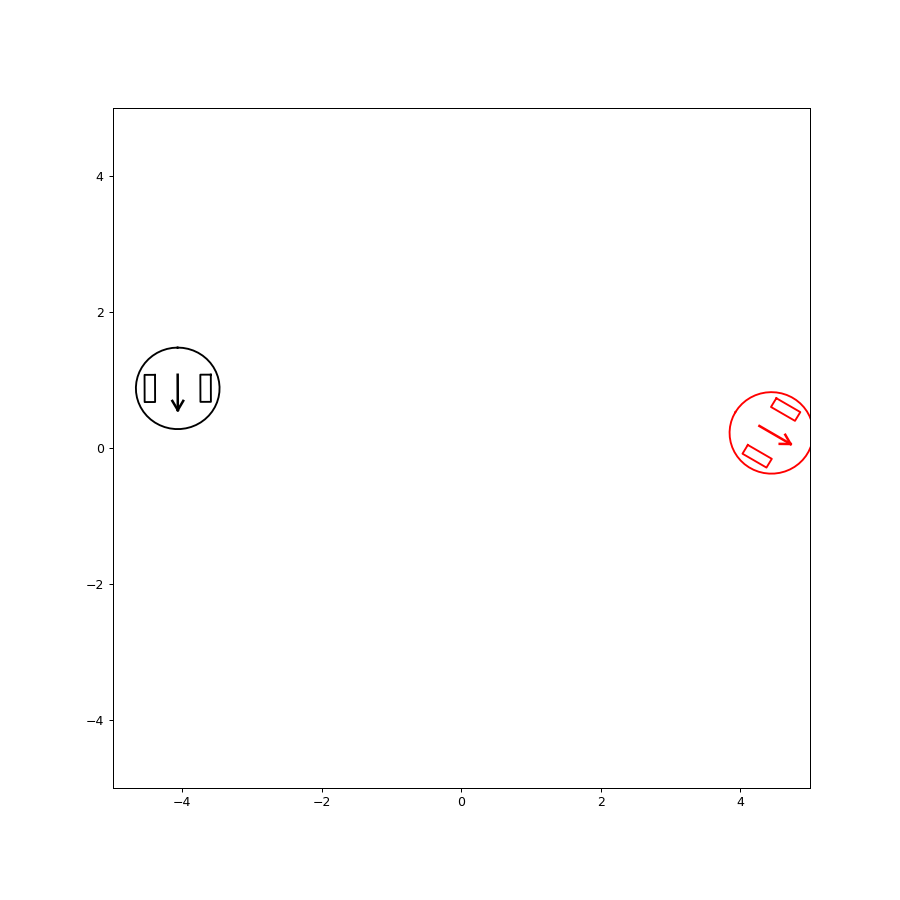

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [9]:
env = gym.make(args.task)
obs = env.reset()
seq = []
images = []
for i in range(100):
    obs, reward, done, info = env.step(policy_forward(policy, obs))
    env.render()
    plt.savefig('tmp.png')
    images.append(plt.imread('tmp.png'))
    
    if done:
        break
imageio.mimsave('xxx.gif', images, duration = 0.1)